In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
! pip3 install torch torchvision torchaudio

In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [6]:
class StrawberryDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [int(path.parent.name) - 2 for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image = image.convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            y = torch.Tensor([label]).to(torch.float32).item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
TRAIN_DIR_1 = Path('/content/gdrive/MyDrive/agrocode/data_6')

train_val_files = sorted(list(TRAIN_DIR_1.rglob('*.jpg')) + list(TRAIN_DIR_1.rglob('*.JPG')) + list(TRAIN_DIR_1.rglob('*.png')) + list(TRAIN_DIR_1.rglob('*.PNG')) + list(TRAIN_DIR_1.rglob('*.jpeg')) + list(TRAIN_DIR_1.rglob('*.JPEG')))

In [8]:
len(train_val_files)

556

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [10]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [11]:
from sklearn.metrics import mean_absolute_error
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    maes = []
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs).squeeze(1)
        labels = labels.to(torch.float32)
        # print(outputs.dtype, labels.dtype)
        loss = criterion(outputs, labels).float()
        loss.backward()
        optimizer.step()
        processed_data += inputs.size(0)
        running_loss += loss.item() * inputs.size(0)
        mae = mean_absolute_error(labels.cpu().detach(), outputs.cpu().detach())
        maes.append(mae)
              
    train_loss = running_loss / processed_data
    train_acc = np.array(maes).mean()
    return train_loss, train_acc

In [12]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [13]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    max_acc = 0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_mae {t_acc:0.4f} val_mae {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.MSELoss()
        scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion) 
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc> max_acc:
              max_acc = val_acc
              torch.save(model.state_dict(), '/content/gdrive/MyDrive/agrocode/weights/growthlev_{}'.format(round(100 * float(max_acc))))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [14]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [15]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [16]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:

val_dataset = StrawberryDataset(val_files, mode='val')
    
train_dataset = StrawberryDataset(train_files, mode='train')

In [18]:
densenet_frozed,_=initialize_model("densenet", 1, feature_extract=True, use_pretrained=True)
densenet_frozed.cuda()
history = train(train_dataset, val_dataset, model=densenet_frozed, epochs=5, batch_size=64)
torch.save(densenet_frozed.state_dict(), "gdrive/My Drive/agrocode/densenet_frozed_final.pth") 

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 8.830925322867728


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:  20%|██        | 1/5 [04:23<17:32, 263.03s/it]


Epoch 001 train_loss: 8.8309     val_loss 6.5696 train_mae 2.1026 val_mae 0.0089
loss 6.418684130316382


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:  40%|████      | 2/5 [06:37<09:22, 187.37s/it]


Epoch 002 train_loss: 6.4187     val_loss 6.6609 train_mae 2.1524 val_mae 0.0089
loss 6.477579056679666


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:  60%|██████    | 3/5 [08:52<05:26, 163.27s/it]


Epoch 003 train_loss: 6.4776     val_loss 6.5080 train_mae 2.2594 val_mae 0.0089
loss 6.041617092785534


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:  80%|████████  | 4/5 [11:06<02:31, 151.90s/it]


Epoch 004 train_loss: 6.0416     val_loss 6.2366 train_mae 2.1020 val_mae 0.0089
loss 5.831891635516742


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([48])) that is different to the input size (torch.Size([48, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch: 100%|██████████| 5/5 [13:20<00:00, 160.19s/it]



Epoch 005 train_loss: 5.8319     val_loss 6.3014 train_mae 1.9387 val_mae 0.0089


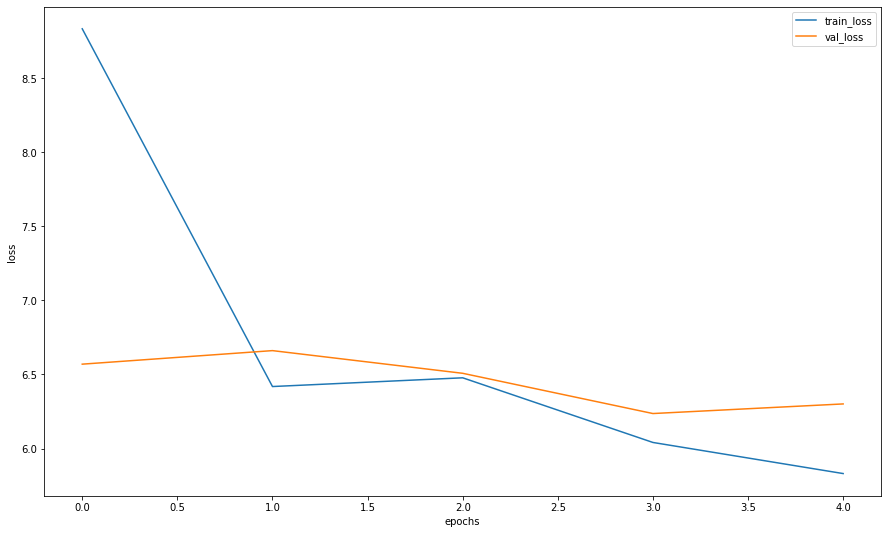

In [21]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [20]:
torch.save(densenet_frozed.state_dict(), "gdrive/My Drive/agrocode/weights/growth_levels") 

In [280]:
import os
import torch
import numpy as np
import collections
from PIL import Image
from cv2 import cv2
from torchvision import models, transforms
import torchvision.transforms.functional as F
import torch.nn as nn
from typing import Dict, List, Set


class RulerService:
    def __init__(
            self,
            growth_measure_path: str = "gdrive/My Drive/agrocode/weights/growth_levels"):
        self.RESCALE_SIZE = 224
        self.growth_measure_path = growth_measure_path
        self._levelmeasure = None
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])


    def prepare_photo(self, photo_path: str) -> np.array:
        image = Image.open(photo_path)
        image.load()
        image = image.resize((self.RESCALE_SIZE, self.RESCALE_SIZE))
        image = np.array(image)
        image = np.array(image / 255, dtype='float32')
        image = self.transform(image)
        return image.unsqueeze(0)

    def predict_level(self, photo_path: str) -> int:
        return round(self.levelmeasure(self.prepare_photo(photo_path)).item())


    # load levelmeasure model lazily for graphic memory saving
    @property
    def levelmeasure(self):
        if self._levelmeasure is None:
            self._set_levelmeasure()
        return self._levelmeasure

    def _set_levelmeasure(self):
        self._levelmeasure = models.densenet121(pretrained=True)
        num_ftrs = self._levelmeasure.classifier.in_features
        self._levelmeasure.classifier = nn.Linear(num_ftrs, 1)
        self._levelmeasure.load_state_dict(torch.load(self.growth_measure_path, map_location=torch.device('cpu')))
        self._levelmeasure.eval()



In [281]:
Ruler = RulerService()
Ruler.predict_level('3.jpeg')

4